## **Understanding the DVS Dataset**

In [2]:
#necessary imports
import tonic
from tonic import transforms
import numpy as np
import matplotlib.pyplot as plt

/home/charaf/miniconda3/envs/lava/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To understand what does the data looks like, i imported it and tried to vizualize it without applying any transform

In [3]:
# loading the dataset
dataset = tonic.datasets.DVSGesture(save_to='/home/charaf/VisualAttention_DVS/', train=True)

In [4]:
#selecting a sample
events, label = dataset[0]

In [5]:
#plotting data in raw form
print(events.shape)
print(events)

(519177,)
[( 60,  51, False,       2) (105,  63, False,       8)
 ( 48, 107,  True,      27) ... (110,  59, False, 7261174)
 (108,  44,  True, 7261196) (110,  45,  True, 7261200)]


Each element in the events array is a tuple representing an individual event from the DVS camera. The tuple structure is l(x, y, polarity, timestamp), where:

x and y are spatial coordinates of the event on the sensor array.


polarity is a boolean value indicating the type of event (increase or decrease in brightness), where False could indicate one polarity and True the opposite.


timestamp is the time at which the event was recorded. It is usually given in microseconds since the start of the recording.

Since events are (x, y, t, p) we need to convert these events into a frame by accumulating events over a time window.

In [6]:
def events_to_frame(events):
    frame = np.zeros((128, 128), dtype=np.float32)  # 128x128 sensor resolution
    for event in events:
        x, y, t, p = event
        frame[y, x] += 1 if p == 1 else -1  # Increase or decrease pixel value based on polarity
    return frame

frame = events_to_frame(events)

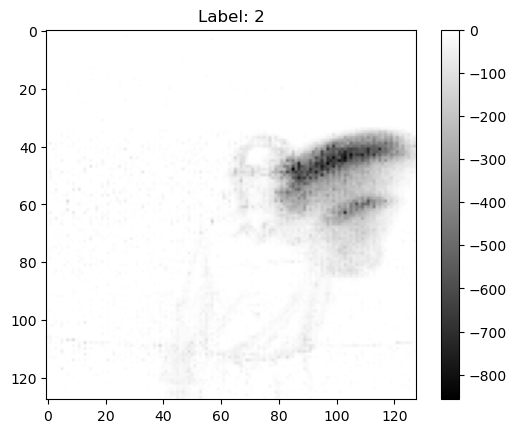

In [7]:
#viz
plt.imshow(frame, cmap='gray')
plt.title(f"Label: {label}")
plt.colorbar()
plt.show()

Now that we know what the data looks like, we need to process the data to be able to feed it to our SNN.

In [8]:
#Turning T/F to 0/1 and downscaling by a factor of 8 to have  a downscaled input window of size 80 × 60 as suggested in Hugo's paper
# Original sensor size (part C améli's peaper)
original_sensor_size = (128, 128)

# Desired sensor size
desired_sensor_size = (15, 15)

# Calculate the scaling factors for x and y dimensions
scale_x = original_sensor_size[0] / desired_sensor_size[0]
scale_y = original_sensor_size[1] / desired_sensor_size[1]

# Apply spatial funneling to downscale the resolution separately for x and y
funneled_events = [
    [int(event[0] // scale_x), int(event[1] // scale_y), int(event[2]), event[3]]
    for event in events
    if int(event[0] // scale_x) < desired_sensor_size[0] and int(event[1] // scale_y) < desired_sensor_size[1]
]

# Verify the downscaling with a small sample
print(funneled_events[:5])

[[7, 5, 0, 2], [12, 7, 0, 8], [5, 12, 1, 27], [5, 12, 1, 27], [2, 7, 1, 36]]


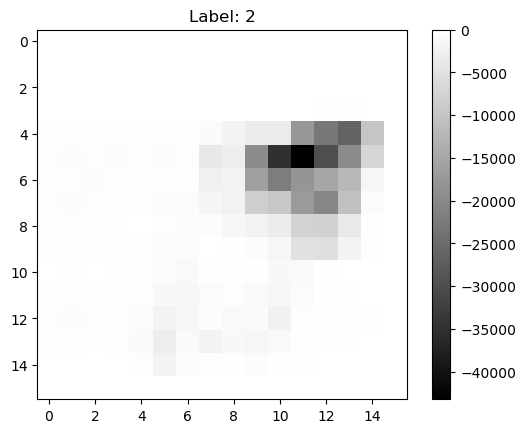

In [9]:
def events_to_frame1 (events):
    frame = np.zeros((16, 16), dtype=np.float32)  # 80*60 sensor resolution
    for event in events:
        x, y, t, p = event
        frame[y, x] += 1 if p == 1 else -1
    return frame

frame1 = events_to_frame1(funneled_events)
plt.imshow(frame1, cmap='gray')
plt.title(f"Label: {label}")
plt.colorbar()
plt.show()